In [109]:
# https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b
from google.colab import drive
from google.colab import files
import pandas as pd

drive.mount('/content/drive')
df_en = pd.read_csv("drive/My Drive/Diploma/second_try/Code/analysis/features_eng.csv")
df_ge = pd.read_csv("drive/My Drive/Diploma/second_try/Code/analysis/features_ge.csv")
df_pl = pd.read_csv("drive/My Drive/Diploma/second_try/Code/analysis/features_pl.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-109-f97cbf7d9ce9>:8: DtypeWarning: Columns (26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ge = pd.read_csv("drive/My Drive/Diploma/second_try/Code/analysis/features_ge.csv")


In [110]:
def transform_category(X_train, col, df):
  mapping = dict(X_train.groupby(col)['category_score'].count()/len(X_train))
  return df[col].apply(lambda x: mapping.get(x, 0))

df_en['category'] = transform_category(df_en, 'category', df_en)
df_en['subcategory'] = transform_category(df_en, 'subcategory', df_en)
df_ge['category'] = transform_category(df_ge, 'category', df_ge)
df_ge['subcategory'] = transform_category(df_ge, 'subcategory', df_ge)
df_pl['category'] = transform_category(df_pl, 'category', df_pl)
df_pl['subcategory'] = transform_category(df_pl, 'subcategory', df_pl)

In [111]:
ev = df_en[df_en['is_event']==1]
ev_en = df_en[df_en['is_event']==1]
ev_ge = df_ge[df_ge['is_event']==1]
ev_pl = df_pl[df_pl['is_event']==1]

In [112]:
col = [ "-1", "Culture",	"Geography",	"History_and_Society",	"STEM",
       'category_score', 'category', 'subcategory',
       'before'  , 'prev_day_views', 'week_before_views', 'month_before_views', 'year_before_views', # 'same_day_views' - same day - do not use, cause it will be -1 for today (api not updated)
       'same_day_revs', 'prev_day_revs', 'week_before_revs', 'month_before_revs', 'year_before_revs' #'same_day_revs' = prev day views,  'day_after_revs'=same day - do not use
       ]

# Clustering, cross-language

In [101]:
!pip install -q pyspark

In [108]:
ev_en.shape, ev_ge.shape, ev_pl.shape

((9674, 32), (688, 35), (512, 32))

In [ ]:
events_all = df_en[df_en['is_event']==1][col].fillna(0)

In [105]:
ev_en[col].fillna(0).shape, ev_ge[col].fillna(0).shape

((9674, 18), (688, 18))

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()
data_customer=spark.createDataFrame(events_all) 
data_customer.printSchema()

# Just clustering and score for # of cluters


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()
data_customer=spark.createDataFrame(df_en[df_en['is_event']==1][col].fillna(0)) 
data_customer.printSchema()


root
 |-- -1: long (nullable = true)
 |-- Culture: long (nullable = true)
 |-- Geography: long (nullable = true)
 |-- History_and_Society: long (nullable = true)
 |-- STEM: long (nullable = true)
 |-- category_score: double (nullable = true)
 |-- category: double (nullable = true)
 |-- subcategory: double (nullable = true)
 |-- before: long (nullable = true)
 |-- prev_day_views: long (nullable = true)
 |-- week_before_views: long (nullable = true)
 |-- month_before_views: long (nullable = true)
 |-- year_before_views: long (nullable = true)
 |-- same_day_revs: double (nullable = true)
 |-- prev_day_revs: double (nullable = true)
 |-- week_before_revs: double (nullable = true)
 |-- month_before_revs: double (nullable = true)
 |-- year_before_revs: double (nullable = true)



In [ ]:
data_customer=data_customer.na.drop() 

In [ ]:
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=col, outputCol='features')
assembled_data=assemble.transform(data_customer)
assembled_data.show(2)

+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+
| -1|Culture|Geography|History_and_Society|STEM|    category_score|          category|       subcategory|before|prev_day_views|week_before_views|month_before_views|year_before_views|same_day_revs|prev_day_revs|week_before_revs|month_before_revs|year_before_revs|            features|
+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+
|  0|      0|        1|                  0|   0|0.8670457601547241|0.2432270004197352|0.2417579272713397|   234|            75|              345|   

In [ ]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+
| -1|Culture|Geography|History_and_Society|STEM|    category_score|          category|       subcategory|before|prev_day_views|week_before_views|month_before_views|year_before_views|same_day_revs|prev_day_revs|week_before_revs|month_before_revs|year_before_revs|            features|        standardized|
+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+
|  0|      0|        1|                  0|   0|0.8670457601547241|0.2432270004197352

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


import time

start = time.time()
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

    
KMeans_algo=KMeans(featuresCol='standardized', k=20)

KMeans_fit=KMeans_algo.fit(data_scale_output)

output=KMeans_fit.transform(data_scale_output)



score=evaluator.evaluate(output)

silhouette_score.append(score)

print("Silhouette Score:",score)

end = time.time()
print(end - start)

Silhouette Score: 0.690640163227935
20.285876274108887


In [ ]:
jj = []
for i in range(50, 0, -5):
    j = int(10000/i)
    print(j)
    jj.append(j)

    KMeans_algo=KMeans(featuresCol='standardized', k=j)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)


200
Silhouette Score: 0.41904673196360664
222
Silhouette Score: 0.4326862886809642
250
Silhouette Score: 0.4217824517167225
285
Silhouette Score: 0.4611960424835246
333
Silhouette Score: 0.4305807864945779
400
Silhouette Score: 0.41836228220894806
500
Silhouette Score: 0.4094338202540252
666
Silhouette Score: 0.4112166044861174
1000
Silhouette Score: 0.3739472519001946
2000
Silhouette Score: 0.3517654497134334


In [ ]:

scores = []
for i in range(100, 5100, 100):

    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    scores.append(score)
    
    print(i,score)

100 0.48891153527408404
200 0.41904673196360664
300 0.4187620603283879
400 0.41836228220894806
500 0.4094338202540252
600 0.4107211934452187
700 0.37541517449784906
800 0.3940824316274041
900 0.3947050968531498
1000 0.3739472519001946
1100 0.3737049784620603
1200 0.35988759080801674
1300 0.3566831529788042
1400 0.36275489699869207
1500 0.3544944909783299
1600 0.3554788447478603
1700 0.35821623449910994
1800 0.34574886076375566
1900 0.36142455430417925
2000 0.3517654497134334
2100 0.35287569728909934
2200 0.3431376595868049
2300 0.35166835421651627
2400 0.34483422245356016
2500 0.3480601756778595
2600 0.33547371311224344
2700 0.33015718430566965
2800 0.3318382399444593
2900 0.31761537555753167
3000 0.3157518535044059
3100 0.32448507726921105
3200 0.3139206993954453
3300 0.30880629275957266
3400 0.31976375240496774
3500 0.31145126991962174
3600 0.3124068131993307
3700 0.2990301317264192
3800 0.30044049051709115
3900 0.2961210235196294
4000 0.2952196044098012
4100 0.29791040404392005
4200

Text(0, 0.5, 'cost')

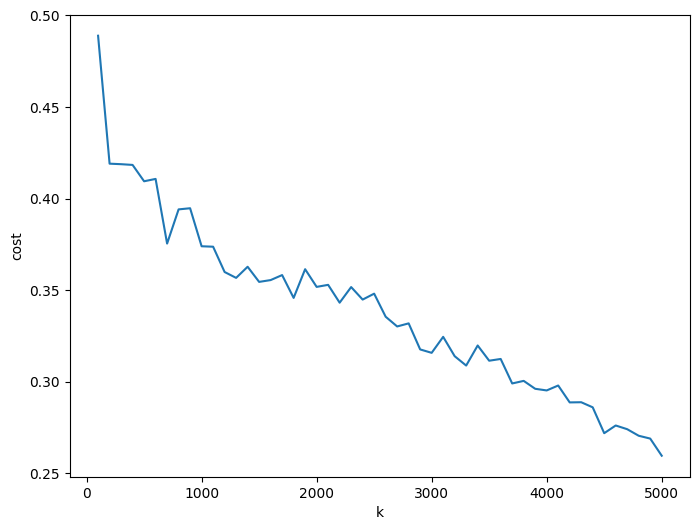

In [ ]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(100, 5100, 100),scores)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


import time

start = time.time()
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

    
KMeans_algo=KMeans(featuresCol='standardized', k=700)

KMeans_fit=KMeans_algo.fit(data_scale_output)

output=KMeans_fit.transform(data_scale_output)



score=evaluator.evaluate(output)

silhouette_score.append(score)

print("Silhouette Score:",score)

end = time.time()
print(end - start)

Silhouette Score: 0.38753267683231857
359.8802390098572


In [ ]:
df_clust = output.toPandas()
df_clust.head(2)

,-1,Culture,Geography,History_and_Society,STEM,category_score,category,subcategory,before,prev_day_views,...,month_before_views,year_before_views,same_day_revs,prev_day_revs,week_before_revs,month_before_revs,year_before_revs,features,standardized,prediction
0,0,0,1,0,0,0.867046,0.243227,0.241758,234,75,...,1681,48322,0.0,0.0,0.0,0.0,25.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.8670457601547241, ...","(0.0, 0.0, 2.057760789906796, 0.0, 0.0, 3.1964...",532
1,0,0,1,0,0,0.972425,0.243227,0.241758,-1,591,...,591,591,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.9724247455596924, ...","(0.0, 0.0, 2.057760789906796, 0.0, 0.0, 3.5849...",0


In [ ]:
set(ev[df_clust['prediction']==370]['page_title'])

{'Andhra_Pradesh',
 'Bangladesh',
 'Brazil',
 'Czech_Republic',
 'Israel',
 'Moldova',
 'Netherlands',
 'Philippines',
 'Poland',
 'Spain',
 'Uzbekistan'}

In [ ]:
set(ev[df_clust['prediction']==239]['page_title'])

{'COVID-19_pandemic_in_Kiribati',
 'COVID-19_pandemic_in_Nauru',
 'COVID-19_pandemic_in_North_America',
 'COVID-19_pandemic_in_North_Korea',
 'COVID-19_pandemic_in_Queensland',
 'COVID-19_pandemic_in_Shanghai',
 'COVID-19_pandemic_in_Victoria',
 'COVID-19_pandemic_in_Western_Australia',
 'COVID-19_pandemic_in_the_Northern_Territory',
 'COVID-19_pandemic_in_the_Pitcairn_Islands',
 'COVID-19_vaccination_in_the_United_States',
 'Matanzas_oil_storage_facility_explosion'}

In [ ]:
set(ev[df_clust['prediction']==690]['page_title'])

{'Amazon_rainforest',
 'Avalanche',
 'COVID-19_pandemic_in_Italy',
 'COVID-19_pandemic_in_Texas',
 'Censorship_of_Wikipedia',
 'Filling_station',
 'Fireworks',
 'Fireworks_show',
 'Storage_depot'}

In [ ]:
set(ev[df_clust['prediction']==481]['page_title'])

{'2022_European_and_Mediterranean_wildfires',
 '2022_Russia%E2%80%93Ukraine_peace_negotiations',
 'Battle_of_Melitopol',
 'Boko_Haram_insurgency',
 'Ethiopia%E2%80%93Tigray_peace_agreement',
 'Protests_against_the_2022_Russian_invasion_of_Ukraine',
 'Reactions_to_the_2021%E2%80%932022_Russo-Ukrainian_crisis',
 'Somali_Civil_War_(2009%E2%80%93present)',
 'Transnistria_conflict',
 'Whisky_War'}

In [ ]:
set(ev[df_clust['prediction']==579]['page_title'])

{'United_Kingdom'}

In [ ]:
df_clust.groupby(['prediction'])['prediction'].count().sort_values().tail(100)

prediction
370      19
239      19
690      19
481      19
579      19
       ... 
670     244
444     259
0       335
678     405
378    1065
Name: prediction, Length: 100, dtype: int64

# Clustering with text info

In [113]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Clustering using K-Means').getOrCreate()
data_customer=spark.createDataFrame(df_en[df_en['is_event']==1][col+['page_title']].fillna(0)) 

In [114]:
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.feature import HashingTF, IDF, Tokenizer


tokenizer = Tokenizer(inputCol="page_title", outputCol="words")
wordsData = tokenizer.transform(data_customer)


hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

rescaledData.show(2)

+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+--------------+--------------------+
| -1|Culture|Geography|History_and_Society|STEM|    category_score|          category|       subcategory|before|prev_day_views|week_before_views|month_before_views|year_before_views|same_day_revs|prev_day_revs|week_before_revs|month_before_revs|year_before_revs|          page_title|               words|   rawFeatures|            features|
+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+--------------

In [115]:
rescaledData = rescaledData.drop("page_title")
rescaledData = rescaledData.drop("words")
rescaledData = rescaledData.drop("rawFeatures")
rescaledData.printSchema()
rescaledData=rescaledData.na.drop() 

root
 |-- -1: long (nullable = true)
 |-- Culture: long (nullable = true)
 |-- Geography: long (nullable = true)
 |-- History_and_Society: long (nullable = true)
 |-- STEM: long (nullable = true)
 |-- category_score: double (nullable = true)
 |-- category: double (nullable = true)
 |-- subcategory: double (nullable = true)
 |-- before: long (nullable = true)
 |-- prev_day_views: long (nullable = true)
 |-- week_before_views: long (nullable = true)
 |-- month_before_views: long (nullable = true)
 |-- year_before_views: long (nullable = true)
 |-- same_day_revs: double (nullable = true)
 |-- prev_day_revs: double (nullable = true)
 |-- week_before_revs: double (nullable = true)
 |-- month_before_revs: double (nullable = true)
 |-- year_before_revs: double (nullable = true)
 |-- features: vector (nullable = true)



In [116]:
from pyspark.ml.feature import VectorAssembler
data_customer.columns
assemble=VectorAssembler(inputCols=col+['features'], outputCol='all_features')
assembled_data=assemble.transform(rescaledData)
assembled_data.show(2)

+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+
| -1|Culture|Geography|History_and_Society|STEM|    category_score|          category|       subcategory|before|prev_day_views|week_before_views|month_before_views|year_before_views|same_day_revs|prev_day_revs|week_before_revs|month_before_revs|year_before_revs|            features|        all_features|
+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+
|  0|      0|        1|                  0|   0|0.8670457601547241|0.2432270004197352

In [117]:
from pyspark.ml.feature import StandardScaler
scale=StandardScaler(inputCol='all_features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)
data_scale_output.show(2)

+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+--------------------+
| -1|Culture|Geography|History_and_Society|STEM|    category_score|          category|       subcategory|before|prev_day_views|week_before_views|month_before_views|year_before_views|same_day_revs|prev_day_revs|week_before_revs|month_before_revs|year_before_revs|            features|        all_features|        standardized|
+---+-------+---------+-------------------+----+------------------+------------------+------------------+------+--------------+-----------------+------------------+-----------------+-------------+-------------+----------------+-----------------+----------------+--------------------+--------------------+--------------------+
|  0|      0|        1

In [118]:

scores = []
for i in range(100, 5100, 100):

    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    score=evaluator.evaluate(output)
    
    scores.append(score)
    
    print(i,score)

100 0.7905750753523116
200 0.7647998422627247
300 0.6514414411409163
400 0.6517832674099523
500 0.6426240579925464
600 0.6173327530833604
700 0.5789748116928084
800 0.5461583447392842
900 0.5643059475911484
1000 0.5414241377675847
1100 0.544000716155587
1200 0.5140712814897878
1300 0.5186244630643937
1400 0.5162634468044374
1500 0.49420749545470066
1600 0.48378806858388634
1700 0.48779713189043533
1800 0.4877409916245311
1900 0.47492429107758205
2000 0.47196502095841275
2100 0.4716984841171676
2200 0.4635077938673101
2300 0.4646640469283894
2400 0.46512970511587914
2500 0.4462555081768504
2600 0.44446544398440924
2700 0.43719337240549183
2800 0.4352650943150367
2900 0.43685789497033545
3000 0.4319702391801967
3100 0.42094756518470355
3200 0.4210499188906422
3300 0.420341681504486
3400 0.4092221146105173
3500 0.40491123259654904
3600 0.4056814328285662
3700 0.39092624108096696
3800 0.3907888832542055
3900 0.3884476537270983
4000 0.3809959965099012
4100 0.3812928959471002
4200 0.37314907

In [119]:
scores

[0.7905750753523116,
 0.7647998422627247,
 0.6514414411409163,
 0.6517832674099523,
 0.6426240579925464,
 0.6173327530833604,
 0.5789748116928084,
 0.5461583447392842,
 0.5643059475911484,
 0.5414241377675847,
 0.544000716155587,
 0.5140712814897878,
 0.5186244630643937,
 0.5162634468044374,
 0.49420749545470066,
 0.48378806858388634,
 0.48779713189043533,
 0.4877409916245311,
 0.47492429107758205,
 0.47196502095841275,
 0.4716984841171676,
 0.4635077938673101,
 0.4646640469283894,
 0.46512970511587914,
 0.4462555081768504,
 0.44446544398440924,
 0.43719337240549183,
 0.4352650943150367,
 0.43685789497033545,
 0.4319702391801967,
 0.42094756518470355,
 0.4210499188906422,
 0.420341681504486,
 0.4092221146105173,
 0.40491123259654904,
 0.4056814328285662,
 0.39092624108096696,
 0.3907888832542055,
 0.3884476537270983,
 0.3809959965099012,
 0.3812928959471002,
 0.3731490795919679,
 0.36825118343510405,
 0.3681763903329006,
 0.36030445005641737,
 0.3523393885368762,
 0.34937433758279873,


Text(0, 0.5, 'cost')

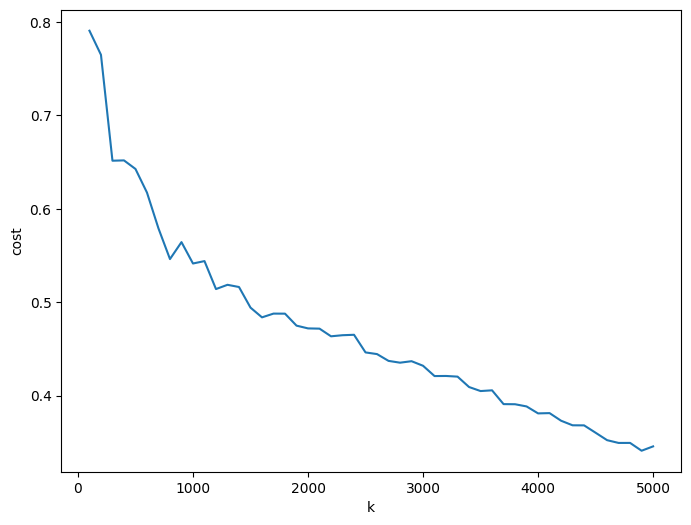

In [120]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(100, 5100, 100),scores)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [121]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


import time

start = time.time()
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

    
KMeans_algo=KMeans(featuresCol='standardized', k=800)

KMeans_fit=KMeans_algo.fit(data_scale_output)

output=KMeans_fit.transform(data_scale_output)



score=evaluator.evaluate(output)

silhouette_score.append(score)

print("Silhouette Score:",score)

end = time.time()
print(end - start)

Silhouette Score: 0.5461583447392842
368.8319115638733


In [122]:
df_clust_2 = output.toPandas()
df_clust_2.head(2)

,-1,Culture,Geography,History_and_Society,STEM,category_score,category,subcategory,before,prev_day_views,...,year_before_views,same_day_revs,prev_day_revs,week_before_revs,month_before_revs,year_before_revs,features,all_features,standardized,prediction
0,0,0,1,0,0,0.867046,0.243227,0.241758,234,75,...,48322,0.0,0.0,0.0,0.0,25.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 2.9487895143067995, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.8670457601547241, ...","(0.0, 0.0, 2.057760789906796, 0.0, 0.0, 3.1964...",151
1,0,0,1,0,0,0.972425,0.243227,0.241758,-1,591,...,591,0.0,0.0,0.0,0.0,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 2.9487895143067995, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.9724247455596924, ...","(0.0, 0.0, 2.057760789906796, 0.0, 0.0, 3.5849...",151


Text(0, 0.5, 'number of clusters')

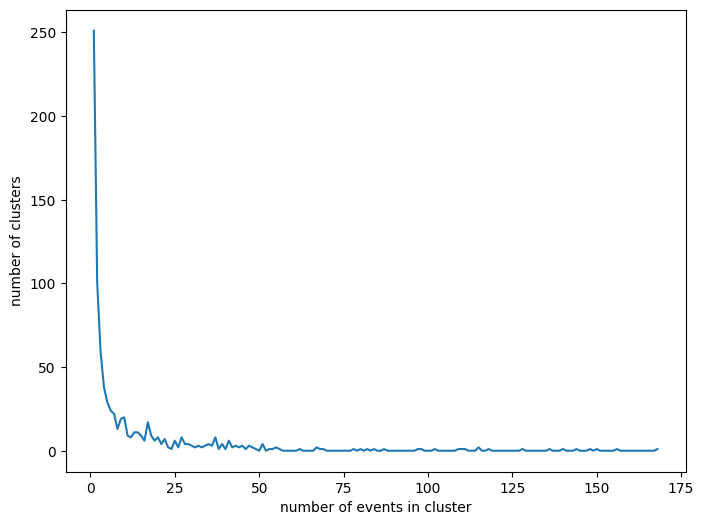

In [135]:
counts = list(df_clust_2.groupby(['prediction'])['prediction'].count().sort_values(ascending=False))
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(1, 169),[counts.count(i) for i in range(1, 169)])
ax.set_xlabel('number of events in cluster')
ax.set_ylabel('number of clusters')

Text(0, 0.5, 'cost')

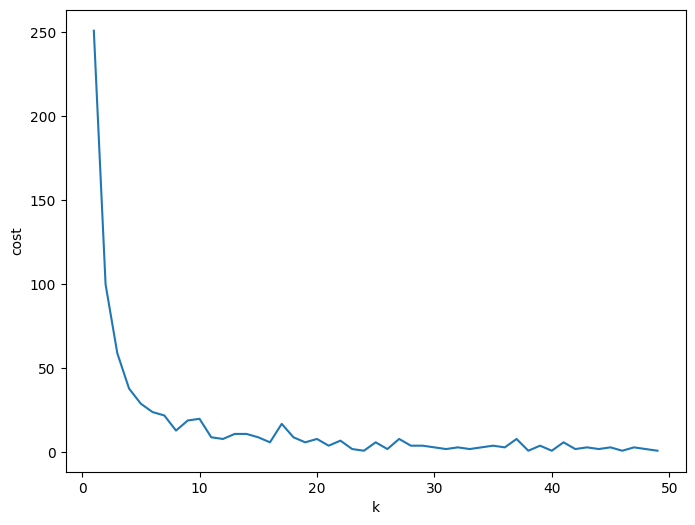

In [134]:
counts = list(df_clust_2.groupby(['prediction'])['prediction'].count().sort_values(ascending=False))
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(1, 50),[counts.count(i) for i in range(1, 50)])
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [130]:
list(df_clust_2.groupby(['prediction'])['prediction'].count().sort_values(ascending=False))#.iloc[-150::-1].index

[168,
 156,
 150,
 148,
 144,
 140,
 136,
 128,
 118,
 115,
 115,
 111,
 110,
 109,
 102,
 98,
 97,
 87,
 84,
 82,
 80,
 78,
 69,
 68,
 67,
 67,
 62,
 56,
 55,
 55,
 54,
 53,
 51,
 51,
 51,
 51,
 49,
 48,
 48,
 47,
 47,
 47,
 46,
 45,
 45,
 45,
 44,
 44,
 43,
 43,
 43,
 42,
 42,
 41,
 41,
 41,
 41,
 41,
 41,
 40,
 39,
 39,
 39,
 39,
 38,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 37,
 36,
 36,
 36,
 35,
 35,
 35,
 35,
 34,
 34,
 34,
 33,
 33,
 32,
 32,
 32,
 31,
 31,
 30,
 30,
 30,
 29,
 29,
 29,
 29,
 28,
 28,
 28,
 28,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 27,
 26,
 26,
 25,
 25,
 25,
 25,
 25,
 25,
 24,
 23,
 23,
 22,
 22,
 22,
 22,
 22,
 22,
 22,
 21,
 21,
 21,
 21,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 20,
 19,
 19,
 19,
 19,
 19,
 19,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 18,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 17,
 16,
 16,
 16,
 16,
 16,
 16,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 15,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,
 14,


In [137]:
for i in df_clust_2.groupby(['prediction'])['prediction'].count().sort_values(ascending=False).iloc[100:].index:
  print(i, len(df_clust_2[df_clust_2['prediction']==i]))
  print(set(ev[df_clust_2['prediction']==i]['page_title']))
  print()
  print()

24 28
{'Kazakhs', 'Ukrainian_Navy', '2022_German_presidential_election', 'Colombo', 'Economy_of_Greece', 'Exile_of_Gotabaya_Rajapaksa', '2022_Albanian_presidential_election', 'Finland%E2%80%93Russia_relations', '10_Downing_Street', 'Federal_Supreme_Council', '%C3%9Cr%C3%BCmqi', 'Berdiansk', 'Melbourne_Cup', 'President_of_Kazakhstan', 'Louisville,_Kentucky', 'Mississippi', 'Lions%27_Den_(militant_group)', '2022_Latvian_parliamentary_election', '2022_South_Australian_state_election', 'Somali_Civil_War_(2009%E2%80%93present)', 'Ukrainian_Soviet_Socialist_Republic'}


441 27
{'European_Parliament', 'Politics_of_Transnistria', '2022_Antananarivo_floods', 'Column_(formation)', 'Ministry_of_Foreign_Affairs_(Turkey)', '2022_V-22_Osprey_plane_crash', 'Kay-Achim_Sch%C3%B6nbach', '2022_East_London_tavern_disaster', 'AIDAnova', 'Turkish_Air_Force', '2022_vote_of_confidence_in_the_Johnson_ministry', '2022_Italian_referendum', 'Ritual_warfare', 'Yaound%C3%A9_nightclub_fire', '2022_National_Party_of_

In [136]:
#622 33
# {'Airbus_A319', 'Hurricane_Julia_(2022)', 'Satellite_imagery', 'Philippine_Institute_of_Volcanology_and_Seismology', '2022_monkeypox_outbreak_in_the_United_States', '2022_Papua_New_Guinea_earthquake', 'January_2022_Afghanistan_earthquake'}

#394 37
#{'Russian_occupation_of_Kharkiv_Oblast', '2022_missile_explosion_in_Poland', 'Azovstal_iron_and_steel_works', 'Battle_of_Irpin', 'Russian_annexation_of_Southern_and_Eastern_Ukraine', '2022_Marmolada_serac_collapse', 'Eastern_Ukraine_offensive', 'Security_Service_of_Ukraine'}

13 43
{'Birth_control', 'Treatment_and_management_of_COVID-19', 'List_of_government_space_agencies', 'COVID-19_pandemic_in_Finland', 'Impact_of_the_COVID-19_pandemic_on_the_performing_arts', 'COVID-19_pandemic_deaths', 'COVID-19_pandemic_in_Egypt', 'Sanofi%E2%80%93GSK_COVID-19_vaccine', '2022_monkeypox_outbreak_in_Canada', 'COVID-19_pandemic_in_Iraq', '2022_monkeypox_outbreak_in_North_America', 'Wildfire', 'Chlorine_gas', 'Stampede#Human_stampedes', 'Jupiter', 'COVID-19_pandemic_in_the_Dominican_Republic', 'Oil_refinery', 'COVID-19_pandemic_in_North_Dakota', 'Earthquake', 'COVID-19_pandemic_in_Denmark'}


619 49
{'COVID-19_pandemic'}

489 31
{'Russo-Ukrainian_War'}

661 37
{'Russo-Ukrainian_War'}



475 31
{'Naval_gunfire_support', 'Izhevsk_school_shooting', '2022_Petr%C3%B3polis_floods', '2022_Chilean_national_plebiscite', 'Prison_riot', '2022_Dallas_airshow_mid-air_collision', 'West_Virginia_v._EPA', 'Royal_Saudi_Air_Force', 'Anti-ship_missile', 'Insurgency_in_Northern_Chad', '2022_Nobel_Memorial_Prize_in_Economic_Sciences', 'Cargo_ship', '2022_Kazakh_presidential_election', 'Vila-seca_train_crash', 'Ethiopian_Air_Force', 'People%27s_Party_of_Andalusia', 'Sistan_and_Baluchestan_insurgency', 'Conservative_Party_(UK)', '2022_Mazar-i-Sharif_mosque_bombing', '2022_Kansas_Value_Them_Both_Amendment', 'Islamic_Revolutionary_Guard_Corps_Navy'}

SyntaxError: ignored

In [ ]:
set(ev[df_clust_2['prediction']==104]['page_title'])

{'COVID-19_pandemic_in_Africa',
 'COVID-19_pandemic_in_Greece',
 'COVID-19_pandemic_in_Serbia',
 'COVID-19_pandemic_in_the_United_Kingdom'}

In [ ]:
set(ev[df_clust_2['prediction']==112]['page_title'])

{'2022_Bermondsey_stabbing',
 '2022_Eastern_Australia_floods',
 '2022_India%E2%80%93Bangladesh_floods',
 '2022_Sacramento_shooting',
 '2022_Seytenga_massacre',
 '2022_Swiss_referendums',
 '2022_Turkmenistan_presidential_election',
 'Anarkali_Bazaar',
 'Annexation_of_Southern_and_Eastern_Ukraine',
 'Australian_Defence_Force',
 'Azov_Battalion',
 'Beijing_Sitong_Bridge_protest',
 'Belarus%E2%80%93Ukraine_relations',
 'Bernalillo_County_Sheriff%27s_Office',
 'COVID-19_anti-lockdown_protests_in_New_Zealand',
 'Caimito,_San_Juan,_Puerto_Rico',
 'Capit%C3%B3lio',
 'Carl_XVI_Gustaf',
 'Central_Equatoria',
 'Changsha_building_collapse',
 'Chinese_space_program',
 'Constitutional_Court_of_Peru',
 'Damascus',
 'Darya_Dugina',
 'Deforestation_of_the_Amazon_rainforest',
 'Drone_strikes_in_Afghanistan',
 'Eastern_Ukraine',
 'Elections_in_Spain',
 'Face_masks_during_the_COVID-19_pandemic_in_the_United_States',
 'Fall_of_Kabul_(2021)',
 'Foreign_relations_of_Iran',
 'French_people',
 'Governor_of_Okl

In [ ]:
ev[df_clust_2['prediction']==154]

,Unnamed: 0.1,Unnamed: 0,page_title,date,around,before,boost,same_day_views,prev_day_views,week_before_views,...,year_before_revs,week_after_revs,day_after_revs,day_after_2_revs,subcategory,-1,Culture,Geography,History_and_Society,STEM
64,64,64,Al-Shabaab_(militant_group),20220103,4823,3825,1.260915,1133,2023,6666,...,129.0,1.0,0.0,0.0,Politics_and_government,0,0,0,1,0
1187,1195,1195,Shin_Bet,20220208,5552,3900,1.423590,1524,2388,7035,...,37.0,0.0,0.0,0.0,Politics_and_government,0,0,0,1,0
1524,1536,1536,Al-Shabaab_(militant_group),20220219,5870,4857,1.208565,1487,2487,8259,...,119.0,3.0,-1.0,0.0,Politics_and_government,0,0,0,1,0
1750,1765,1765,Anti-war_movement,20220224,4477,1336,3.351048,1378,1755,3352,...,30.0,10.0,-1.0,0.0,Military_and_warfare,0,0,0,1,0
1868,1895,1895,Anti-war_movement,20220226,5371,2600,2.065769,948,2404,5244,...,36.0,4.0,0.0,0.0,Military_and_warfare,0,0,0,1,0
1932,1961,1961,Anti-war_movement,20220227,4798,3821,1.255692,849,1797,5853,...,36.0,4.0,0.0,0.0,Military_and_warfare,0,0,0,1,0
2375,2425,2425,Anti-war_movement,20220305,5175,3841,1.347305,1278,2021,6810,...,40.0,0.0,0.0,0.0,Military_and_warfare,0,0,0,1,0
2409,2460,2460,Anti-war_movement,20220306,5431,3735,1.454083,1300,2578,7162,...,39.0,0.0,0.0,0.0,Military_and_warfare,0,0,0,1,0
2698,2761,2761,Anti-war_movement,20220312,3875,5178,0.748358,677,1418,7874,...,38.0,0.0,0.0,0.0,Military_and_warfare,0,0,0,1,0
2748,2814,2814,Anti-war_movement,20220313,3666,4619,0.793678,702,1379,7298,...,38.0,0.0,0.0,0.0,Military_and_warfare,0,0,0,1,0
